>[Noise Generator](#scrollTo=HQYhoUhMP4jQ)

>[Noise Loader](#scrollTo=COyAi4jDQyxa)

>[Raw CEVAE without noise](#scrollTo=vIycJC2dSdjo)

>[Raw CEVAE with noise level 1](#scrollTo=ERould34S43I)

>[Raw CEVAE with noise level 2](#scrollTo=xekGFsGaS5us)

>[Raw CEVAE with noise level 3](#scrollTo=I2b3WVqXS6Fg)

>[Raw CEVAE with noise level 4](#scrollTo=u6FOLXrAS6Z1)

>[Raw CEVAE with noise level 5](#scrollTo=bgNnJ88XS6zA)

>[Fuzzy CEVAE without noise](#scrollTo=EnBxM595Uc-r)

>[Fuzzy CEVAE with noise level 1](#scrollTo=pmyY3JS8UdJy)

>[Fuzzy CEVAE with noise level 2](#scrollTo=1sSlsyoEVD4n)

>[Fuzzy CEVAE with noise level 3](#scrollTo=tXoB2j_QVkbU)

>[Fuzzy CEVAE with noise level 4](#scrollTo=RMjQaS9XUdpk)

>[Fuzzy CEVAE with noise level 5](#scrollTo=pDO1fSzEgIL2)

>[Test result demonstration](#scrollTo=-iDJ6-q8fiS5)



#Noise Generator

In [ ]:
import numpy as np
mu, sigma = 1, 0.5
noise1=np.random.normal(mu, sigma, [747,30])

mu, sigma = 2, 0.5
noise2=np.random.normal(mu, sigma, [747,30])

mu, sigma = 3, 0.5
noise3=np.random.normal(mu, sigma, [747,30])

mu, sigma = 4, 0.5
noise4=np.random.normal(mu, sigma, [747,30])

mu, sigma = 5, 0.5
noise5=np.random.normal(mu, sigma, [747,30])

#====================================================
np.savetxt('zero_point_one.txt',noise1, delimiter= ',')
np.savetxt('zero_point_two.txt',noise2, delimiter= ',')
np.savetxt('zero_point_three.txt',noise3, delimiter= ',')
np.savetxt('zero_point_four.txt',noise4, delimiter= ',')
np.savetxt('zero_point_five.txt',noise5, delimiter= ',')
#====================================================
from google.colab import files
files.download('zero_point_one.txt')
files.download('zero_point_two.txt')
files.download('zero_point_three.txt')
files.download('zero_point_four.txt')
files.download('zero_point_five.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Noise Loader 

In [ ]:
import numpy as np
from google.colab import files
files.upload()
noise1=np.loadtxt('zero_point_one.txt' , delimiter=',')
noise2=np.loadtxt('zero_point_two.txt' , delimiter=',')
noise3=np.loadtxt('zero_point_three.txt' , delimiter=',')
noise4=np.loadtxt('zero_point_four.txt' , delimiter=',')
noise5=np.loadtxt('zero_point_five.txt' , delimiter=',')

KeyboardInterrupt: ignored

#**Raw** CEVAE without noise















In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 5.2 MB/s 
     |████████████████████████████████| 326 kB 37.0 MB/s 
     |████████████████████████████████| 1.8 MB 36.5 MB/s 
     |████████████████████████████████| 678 kB 58.3 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496030 sha256=e9341d5948b94c8bee74cbd3ad074fd688892915043f8777040dd429f7ee59eb
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465077 sha256=77d7e531258d0c8b6ae4669a765735fb78994ef8fa56aa563ea7b26402b373c1
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

%matplotlib inline

warnings.filterwarnings('ignore')
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)

plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols

df = pd.concat([df]*100, ignore_index=True)
# set which features are binary
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# set which features are continuous
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features with binary first and continuous after
perm = binfeats + contfeats

df = df.reset_index(drop=True)
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 82.7354
DEBUG 	 step   100 loss = 31.0446
DEBUG 	 step   200 loss = 27.2426


In [ ]:
ite_train = cevae.predict(X_train)
ite_val = cevae.predict(X_val)

 INFO 	 Evaluating 60 minibatches 
 DEBUG 	 batch ate = 3.8331 
 DEBUG 	 batch ate = 3.83838 
 DEBUG 	 batch ate = 3.83234


In [ ]:

ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

#Raw CEVAE with noise level 1

In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 8.2 MB/s 
     |████████████████████████████████| 326 kB 40.2 MB/s 
     |████████████████████████████████| 1.8 MB 54.2 MB/s 
     |████████████████████████████████| 678 kB 64.0 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496047 sha256=0f8b7b1ec0e3ba1094c3a13d0ef02c4ef5abef1374b7f70831e04b132571244b
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465072 sha256=5b6d8239dd23969a31d27ac29fad429204604d54b46987ed3c6f60d7730d289a
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

%matplotlib inline

warnings.filterwarnings('ignore')
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)

plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols

noise1=pd.DataFrame(noise1)
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
noise1.columns = cols
noise1.head()
noise1['treatment']=0
for i in range(6,25):
  noise1[i]=0
df =noise1+df
df = pd.concat([df]*100, ignore_index=True)
# set which features are binary
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# set which features are continuous
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features with binary first and continuous after
perm = binfeats + contfeats

df = df.reset_index(drop=True)
df.head()
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 100.899
DEBUG 	 step   100 loss = 31.7561
DEBUG 	 step   200 loss = 28.1381


In [ ]:
ite_train = cevae.predict(X_train)
ite_val = cevae.predict(X_val)

INFO 	 Evaluating 60 minibatches
DEBUG 	 batch ate = 3.37103
DEBUG 	 batch ate = 3.39017
DEBUG 	 batch ate = 3.36287
DEBUG 	 batch ate = 3.36249
DEBUG 	 batch ate = 3.38026
DEBUG 	 batch ate = 3.35832
DEBUG 	 batch ate = 3.38052
DEBUG 	 batch ate = 3.35868
DEBUG 	 batch ate = 3.36617
DEBUG 	 batch ate = 3.37753
DEBUG 	 batch ate = 3.34599
DEBUG 	 batch ate = 3.3501
DEBUG 	 batch ate = 3.38862
DEBUG 	 batch ate = 3.38283
DEBUG 	 batch ate = 3.35523
DEBUG 	 batch ate = 3.37277
DEBUG 	 batch ate = 3.36137
DEBUG 	 batch ate = 3.3584
DEBUG 	 batch ate = 3.37714
DEBUG 	 batch ate = 3.39859
DEBUG 	 batch ate = 3.3638
DEBUG 	 batch ate = 3.34852
DEBUG 	 batch ate = 3.38401
DEBUG 	 batch ate = 3.38546
DEBUG 	 batch ate = 3.40981
DEBUG 	 batch ate = 3.36832
DEBUG 	 batch ate = 3.34796
DEBUG 	 batch ate = 3.38023
DEBUG 	 batch ate = 3.35898
DEBUG 	 batch ate = 3.39353
DEBUG 	 batch ate = 3.36177
DEBUG 	 batch ate = 3.36105
DEBUG 	 batch ate = 3.36884
DEBUG 	 batch ate = 3.3485
DEBUG 	 batch ate =

In [ ]:

ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

3.3680806 3.3619676


#Raw CEVAE with noise level 2

In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 30.1 MB/s 
     |████████████████████████████████| 326 kB 47.1 MB/s 
     |████████████████████████████████| 1.8 MB 49.3 MB/s 
     |████████████████████████████████| 678 kB 60.2 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496047 sha256=b4a15ce49b473d7637bb0503f9b5bd03d203ebf533a180c5e15283555e12486f
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465081 sha256=971f0fa7a2a3a551407d877e6d636c5c86be9e8e513d1ca7c33ff01dfb1629a7
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

%matplotlib inline

warnings.filterwarnings('ignore')
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)

plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols

noise2=pd.DataFrame(noise2)
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
noise2.columns = cols
noise2.head()
noise2['treatment']=0
for i in range(6,25):
  noise2[i]=0
df =noise2+df
df = pd.concat([df]*100, ignore_index=True)
# set which features are binary
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# set which features are continuous
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features with binary first and continuous after
perm = binfeats + contfeats

df = df.reset_index(drop=True)
df.head()
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 118.667
DEBUG 	 step   100 loss = 33.357
DEBUG 	 step   200 loss = 29.7835


In [ ]:
ite_train = cevae.predict(X_train)
ite_val = cevae.predict(X_val)

INFO 	 Evaluating 60 minibatches
DEBUG 	 batch ate = 2.67436
DEBUG 	 batch ate = 2.69637
DEBUG 	 batch ate = 2.61959


In [ ]:

ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

#Raw CEVAE with noise level 3

In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 5.1 MB/s 
     |████████████████████████████████| 326 kB 43.4 MB/s 
     |████████████████████████████████| 1.8 MB 48.8 MB/s 
     |████████████████████████████████| 678 kB 45.2 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496032 sha256=664602296e4cdc7f74368ef902131dcac4547eb77ea8d39520847b513309f1d3
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465078 sha256=c8e3e7734938522e98059e7c8f034616dbcb3f3e2464a479dc582bcc72364789
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

%matplotlib inline

warnings.filterwarnings('ignore')
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)

plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols

noise3=pd.DataFrame(noise3)
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
noise3.columns = cols
noise3['treatment']=0
for i in range(6,25):
  noise3[i]=0
df =noise3+df
df = pd.concat([df]*100, ignore_index=True)
# set which features are binary
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# set which features are continuous
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features with binary first and continuous after
perm = binfeats + contfeats

df = df.reset_index(drop=True)
df.head()
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 143.792
DEBUG 	 step   100 loss = 35.7601
DEBUG 	 step   200 loss = 31.6477


In [ ]:
ite_train = cevae.predict(X_train)
ite_val = cevae.predict(X_val)

INFO 	 Evaluating 60 minibatches
DEBUG 	 batch ate = 1.94637
DEBUG 	 batch ate = 1.96215
DEBUG 	 batch ate = 1.92798
DEBUG 	 batch ate = 1.9414
DEBUG 	 batch ate = 1.98558


In [ ]:

ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

#Raw CEVAE with noise level 4

In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 5.0 MB/s 
     |████████████████████████████████| 326 kB 43.7 MB/s 
     |████████████████████████████████| 1.8 MB 44.2 MB/s 
     |████████████████████████████████| 678 kB 41.7 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496047 sha256=fe7b503258324ddc493971d2ee7a225b3ea73f8949d19b8059685886b8055777
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465073 sha256=87eeec9ec4d8a92ef786457a49ea0e3031f9170c3fc18282abbc3ce40dcef752
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

%matplotlib inline

warnings.filterwarnings('ignore')
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)

plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols


noise4=pd.DataFrame(noise4)
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
noise4.columns = cols
noise4['treatment']=0
for i in range(6,25):
  noise4[i]=0
df =noise4+df
df = pd.concat([df]*100, ignore_index=True)
# set which features are binary
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# set which features are continuous
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features with binary first and continuous after
perm = binfeats + contfeats

df = df.reset_index(drop=True)
df.head()
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 183.72
DEBUG 	 step   100 loss = 38.5139
DEBUG 	 step   200 loss = 33.6367


In [ ]:
ite_train = cevae.predict(X_train)
ite_val = cevae.predict(X_val)

INFO 	 Evaluating 60 minibatches
DEBUG 	 batch ate = 1.75067
DEBUG 	 batch ate = 1.75387
DEBUG 	 batch ate = 1.65929
DEBUG 	 batch ate = 1.64516
DEBUG 	 batch ate = 1.78235


In [ ]:

ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

#Raw CEVAE with noise level 5

In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 5.0 MB/s 
     |████████████████████████████████| 326 kB 44.5 MB/s 
     |████████████████████████████████| 1.8 MB 41.2 MB/s 
     |████████████████████████████████| 678 kB 65.6 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496050 sha256=ccf9965b16bd52824c0fde2afb379ac69811f1f5cf002e45244f537612899e3e
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465072 sha256=1d12ae9f6e28358291f0cd8b76cd7fb3f57a74f3a220d9f7c53233eca792c8b2
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

%matplotlib inline

warnings.filterwarnings('ignore')
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)

plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols
noise5=pd.DataFrame(noise5)
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
noise5.columns = cols
noise5['treatment']=0
for i in range(6,25):
  noise5[i]=0
df =noise5+df
df = pd.concat([df]*100, ignore_index=True)
# set which features are binary
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# set which features are continuous
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features with binary first and continuous after
perm = binfeats + contfeats

df = df.reset_index(drop=True)
df.head()
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 183.465
DEBUG 	 step   100 loss = 40.0706
DEBUG 	 step   200 loss = 34.6085


In [ ]:
ite_train = cevae.predict(X_train)
ite_val = cevae.predict(X_val)

INFO 	 Evaluating 60 minibatches
DEBUG 	 batch ate = 0.446495
DEBUG 	 batch ate = 0.585596
DEBUG 	 batch ate = 0.291848
DEBUG 	 batch ate = 0.264217
DEBUG 	 batch ate = 0.539013
DEBUG 	 batch ate = 0.305763
DEBUG 	 batch ate = 0.496336
DEBUG 	 batch ate = 0.426034
DEBUG 	 batch ate = 0.405674
DEBUG 	 batch ate = 0.494637
DEBUG 	 batch ate = 0.344119
DEBUG 	 batch ate = 0.414646
DEBUG 	 batch ate = 0.501483
DEBUG 	 batch ate = 0.527881


In [ ]:

ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

#**Fuzzy** CEVAE without noise

In [ ]:
!pip install causalml


In [ ]:
!git clone https://github.com/joseffaghihi/Causal-fuzzy-CEVAE.git
%cd Causal-fuzzy-CEVAE
%cd First_architecture
%cd Slow(without Cython)
!unzip pyro-dev.zip
%cd pyro-dev
!python setup.py install

In [ ]:
!pip install -U scikit-fuzzy


import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from __future__ import absolute_import, division, print_function
import sys
import matplotlib.pyplot as plt
import logging

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.nn import PyroModule
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan

logger = logging.getLogger(__name__)


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'

cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols

df = pd.concat([df]*100, ignore_index=True)
#print(df.shape)
#precising variables type
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(25) if i not in binfeats]
perm = binfeats + contfeats
df = df.reset_index(drop=True)

X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1 
               else y['y_cfactual'] - y['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 3
batch_size = 1000
learning_rate = 1e-3
learning_rate_decay = 0.1
num_layers =2

import logging
import torch
from pyro.contrib.cevae import CEVAE as CEVAEModel

from causalml.inference.meta.utils import convert_pd_to_np

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)


class CEVAE:
    def __init__(self, outcome_dist="studentt", latent_dim=20, hidden_dim=200, num_epochs=50, num_layers=3,
                 batch_size=100, learning_rate=1e-3, learning_rate_decay=0.1, num_samples=1000, weight_decay=1e-4):
        
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(outcome_dist=self.outcome_dist,
                           feature_dim=X.shape[-1],
                           latent_dim=self.latent_dim,
                           hidden_dim=self.hidden_dim,
                           num_layers=self.num_layers)

        self.cevae.fit(x=torch.tensor(X, dtype=torch.float),
                       t=torch.tensor(treatment, dtype=torch.float),
                       y=torch.tensor(y, dtype=torch.float),
                       num_epochs=self.num_epochs,
                       batch_size=self.batch_size,
                       learning_rate=self.learning_rate,
                       learning_rate_decay=self.learning_rate_decay,
                       weight_decay=self.weight_decay)

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return self.cevae.ite(torch.tensor(X, dtype=torch.float),
                              num_samples=self.num_samples,
                              batch_size=self.batch_size).cpu().numpy()

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

In [ ]:

cevae_model = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

# fit
losses = cevae_model.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 76.8366
DEBUG 	 step   100 loss = 29.2849


In [ ]:
#train 
ite_train = cevae_model.predict(X_train)
ite_val = cevae_model.predict(X_val)

INFO 	 Evaluating 60 minibatches
DEBUG 	 batch ate = 3.99881
DEBUG 	 batch ate = 4.01806
DEBUG 	 batch ate = 4.0137
DEBUG 	 batch ate = 3.99294
DEBUG 	 batch ate = 4.00878
DEBUG 	 batch ate = 3.99197


#Fuzzy CEVAE with noise level 1




In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 5.2 MB/s 
     |████████████████████████████████| 326 kB 38.2 MB/s 
     |████████████████████████████████| 1.8 MB 40.6 MB/s 
     |████████████████████████████████| 678 kB 74.5 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496061 sha256=069176c03a903147e15ab7217f4de31f2d0b93e6575b13881572ed2ddce81b42
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465070 sha256=626c0449e487d48c314c7d974232445c1dfa3535d9832f9fbc121ad95cde577b
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
!git clone https://github.com/joseffaghihi/Causal-fuzzy-CEVAE.git
%cd Causal-fuzzy-CEVAE
%cd First_architecture
%cd Slow(without Cython)
!unzip pyro-dev.zip
%cd pyro-dev
!python setup.py install

Cloning into 'Causal-fuzzy-CEVAE'...
remote: Enumerating objects: 253, done.
remote: Total 253 (delta 0), reused 0 (delta 0), pack-reused 253
Receiving objects: 100% (253/253), 41.40 MiB | 46.69 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/Causal-fuzzy-CEVAE
/content/Causal-fuzzy-CEVAE/First_architecture
/content/Causal-fuzzy-CEVAE/First_architecture/Slow(without Cython)
Archive:  pyro-dev.zip
   creating: pyro-dev/
  inflating: pyro-dev/.codecov.yml   
  inflating: pyro-dev/.coveragerc    
  inflating: pyro-dev/.gitattributes  
   creating: pyro-dev/.github/
  inflating: pyro-dev/.github/issue_template.md  
  inflating: pyro-dev/.gitignore     
  inflating: pyro-dev/.readthedocs.yml  
  inflating: pyro-dev/.travis.yml    
  inflating: pyro-dev/CODE_OF_CONDUCT.md  
  inflating: pyro-dev/CONTRIBUTING.md  
   creating: pyro-dev/docker/
  inflating: pyro-dev/docker/Dockerfile  
  inflating: pyro-dev/docker/install.sh  
  inflating: pyro-dev/docker/Makefile  
  inflating: 

In [ ]:
!pip install -U scikit-fuzzy


import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from __future__ import absolute_import, division, print_function
import sys
import matplotlib.pyplot as plt
import logging

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.nn import PyroModule
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan

logger = logging.getLogger(__name__)


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'

cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]


noise = pd.DataFrame(noise1)



cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
noise.columns = cols
noise.head()
noise['treatment']=0
for i in range(6,25):
  noise[i]=0
df=df+noise
df = pd.concat([df]*100, ignore_index=True)
#print(df.shape)
#precising variables type
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(25) if i not in binfeats]
perm = binfeats + contfeats
df = df.reset_index(drop=True)

X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1 
               else y['y_cfactual'] - y['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 3
batch_size = 1000
learning_rate = 1e-3
learning_rate_decay = 0.1
num_layers =2

import logging
import torch
from pyro.contrib.cevae import CEVAE as CEVAEModel

from causalml.inference.meta.utils import convert_pd_to_np

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)


class CEVAE:
    def __init__(self, outcome_dist="studentt", latent_dim=20, hidden_dim=200, num_epochs=50, num_layers=3,
                 batch_size=100, learning_rate=1e-3, learning_rate_decay=0.1, num_samples=1000, weight_decay=1e-4):
        
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(outcome_dist=self.outcome_dist,
                           feature_dim=X.shape[-1],
                           latent_dim=self.latent_dim,
                           hidden_dim=self.hidden_dim,
                           num_layers=self.num_layers)

        self.cevae.fit(x=torch.tensor(X, dtype=torch.float),
                       t=torch.tensor(treatment, dtype=torch.float),
                       y=torch.tensor(y, dtype=torch.float),
                       num_epochs=self.num_epochs,
                       batch_size=self.batch_size,
                       learning_rate=self.learning_rate,
                       learning_rate_decay=self.learning_rate_decay,
                       weight_decay=self.weight_decay)

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return self.cevae.ite(torch.tensor(X, dtype=torch.float),
                              num_samples=self.num_samples,
                              batch_size=self.batch_size).cpu().numpy()

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

     |████████████████████████████████| 993 kB 5.1 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=4fd12c3927c1a1b45abea36e3493f33fae9076f879eb86f53097e8e5db88b7ca
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

cevae_model = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

# fit
losses = cevae_model.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 92.945
DEBUG 	 step   100 loss = 28.2035


In [ ]:
#train 
ite_train = cevae_model.predict(X_train)
ite_val = cevae_model.predict(X_val)

INFO 	 Evaluating 60 minibatches
DEBUG 	 batch ate = 3.86732


#Fuzzy CEVAE with noise level 2

In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 5.0 MB/s 
     |████████████████████████████████| 326 kB 43.0 MB/s 
     |████████████████████████████████| 1.8 MB 29.4 MB/s 
     |████████████████████████████████| 678 kB 36.1 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496039 sha256=daf4527898d80ffa27cde9324daed55c40d47151b4ff4c8dfbe4da142b32b639
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465067 sha256=8efdaa31de671de239f0f97643b85cd82a15be1cdb3c5f1f568bdc28fa844609
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
!git clone https://github.com/joseffaghihi/Causal-fuzzy-CEVAE.git
%cd Causal-fuzzy-CEVAE
%cd First_architecture
%cd Slow(without Cython)
!unzip pyro-dev.zip
%cd pyro-dev
!python setup.py install

Cloning into 'Causal-fuzzy-CEVAE'...
remote: Enumerating objects: 253, done.
remote: Total 253 (delta 0), reused 0 (delta 0), pack-reused 253
Receiving objects: 100% (253/253), 41.40 MiB | 41.57 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/Causal-fuzzy-CEVAE
/content/Causal-fuzzy-CEVAE/First_architecture
/content/Causal-fuzzy-CEVAE/First_architecture/Slow(without Cython)
Archive:  pyro-dev.zip
   creating: pyro-dev/
  inflating: pyro-dev/.codecov.yml   
  inflating: pyro-dev/.coveragerc    
  inflating: pyro-dev/.gitattributes  
   creating: pyro-dev/.github/
  inflating: pyro-dev/.github/issue_template.md  
  inflating: pyro-dev/.gitignore     
  inflating: pyro-dev/.readthedocs.yml  
  inflating: pyro-dev/.travis.yml    
  inflating: pyro-dev/CODE_OF_CONDUCT.md  
  inflating: pyro-dev/CONTRIBUTING.md  
   creating: pyro-dev/docker/
  inflating: pyro-dev/docker/Dockerfile  
  inflating: pyro-dev/docker/install.sh  
  inflating: pyro-dev/docker/Makefile  
  inflating: 

In [ ]:
!pip install -U scikit-fuzzy


import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from __future__ import absolute_import, division, print_function
import sys
import matplotlib.pyplot as plt
import logging

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.nn import PyroModule
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan

logger = logging.getLogger(__name__)


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'

cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols


noise = pd.DataFrame(noise2)



cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
noise.columns = cols
noise.head()
noise['treatment']=0
for i in range(6,25):
  noise[i]=0
df=df+noise
df = pd.concat([df]*100, ignore_index=True)
#print(df.shape)

#precising variables type
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(25) if i not in binfeats]
perm = binfeats + contfeats
df = df.reset_index(drop=True)

X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1 
               else y['y_cfactual'] - y['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

import logging
import torch
from pyro.contrib.cevae import CEVAE as CEVAEModel

from causalml.inference.meta.utils import convert_pd_to_np

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)


class CEVAE:
    def __init__(self, outcome_dist="studentt", latent_dim=20, hidden_dim=200, num_epochs=50, num_layers=3,
                 batch_size=100, learning_rate=1e-3, learning_rate_decay=0.1, num_samples=1000, weight_decay=1e-4):
        
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(outcome_dist=self.outcome_dist,
                           feature_dim=X.shape[-1],
                           latent_dim=self.latent_dim,
                           hidden_dim=self.hidden_dim,
                           num_layers=self.num_layers)

        self.cevae.fit(x=torch.tensor(X, dtype=torch.float),
                       t=torch.tensor(treatment, dtype=torch.float),
                       y=torch.tensor(y, dtype=torch.float),
                       num_epochs=self.num_epochs,
                       batch_size=self.batch_size,
                       learning_rate=self.learning_rate,
                       learning_rate_decay=self.learning_rate_decay,
                       weight_decay=self.weight_decay)

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return self.cevae.ite(torch.tensor(X, dtype=torch.float),
                              num_samples=self.num_samples,
                              batch_size=self.batch_size).cpu().numpy()

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

     |████████████████████████████████| 993 kB 5.1 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=950b1a5a8496515d293aebb8a8d4a29a8e06ac57972081559f32fcb50df0dd39
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

cevae_model = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

# fit
losses = cevae_model.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 119.712
DEBUG 	 step   100 loss = 34.0267
DEBUG 	 step   200 loss = 29.9475


In [ ]:
#train 
ite_train = cevae_model.predict(X_train)
ite_val = cevae_model.predict(X_val)

INFO 	 Evaluating 60 minibatches
DEBUG 	 batch ate = 2.73567
DEBUG 	 batch ate = 2.82425
DEBUG 	 batch ate = 2.70199
DEBUG 	 batch ate = 2.7217


#Fuzzy CEVAE with noise level 3

In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 5.0 MB/s 
     |████████████████████████████████| 326 kB 60.1 MB/s 
     |████████████████████████████████| 1.8 MB 57.7 MB/s 
     |████████████████████████████████| 678 kB 102.4 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496035 sha256=d60c1dfecd3b445792e0cd7339f51fb8b3bac9b7aea14e22fec338cbb10f0d5f
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465085 sha256=dd41b32b71a8076b32f22017fc1381178d2e7c3c50cd8b8adbbb2afde7a0c4f7
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
!git clone https://github.com/joseffaghihi/Causal-fuzzy-CEVAE.git
%cd Causal-fuzzy-CEVAE
%cd First_architecture
%cd Slow(without Cython)
!unzip pyro-dev.zip
%cd pyro-dev
!python setup.py install

Cloning into 'Causal-fuzzy-CEVAE'...
remote: Enumerating objects: 253, done.
remote: Total 253 (delta 0), reused 0 (delta 0), pack-reused 253
Receiving objects: 100% (253/253), 41.40 MiB | 51.89 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/Causal-fuzzy-CEVAE
/content/Causal-fuzzy-CEVAE/First_architecture
/content/Causal-fuzzy-CEVAE/First_architecture/Slow(without Cython)
Archive:  pyro-dev.zip
   creating: pyro-dev/
  inflating: pyro-dev/.codecov.yml   
  inflating: pyro-dev/.coveragerc    
  inflating: pyro-dev/.gitattributes  
   creating: pyro-dev/.github/
  inflating: pyro-dev/.github/issue_template.md  
  inflating: pyro-dev/.gitignore     
  inflating: pyro-dev/.readthedocs.yml  
  inflating: pyro-dev/.travis.yml    
  inflating: pyro-dev/CODE_OF_CONDUCT.md  
  inflating: pyro-dev/CONTRIBUTING.md  
   creating: pyro-dev/docker/
  inflating: pyro-dev/docker/Dockerfile  
  inflating: pyro-dev/docker/install.sh  
  inflating: pyro-dev/docker/Makefile  
  inflating: 

In [ ]:
!pip install -U scikit-fuzzy


import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from __future__ import absolute_import, division, print_function
import sys
import matplotlib.pyplot as plt
import logging

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.nn import PyroModule
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan

logger = logging.getLogger(__name__)


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'

cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols

 
noise = pd.DataFrame(noise3)



cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
noise.columns = cols
noise.head()
noise['treatment']=0
for i in range(6,25):
  noise[i]=0
df=df+noise
df = pd.concat([df]*100, ignore_index=True)
#print(df.shape)

#precising variables type
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(25) if i not in binfeats]
perm = binfeats + contfeats
df = df.reset_index(drop=True)

X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1 
               else y['y_cfactual'] - y['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

import logging
import torch
from pyro.contrib.cevae import CEVAE as CEVAEModel

from causalml.inference.meta.utils import convert_pd_to_np

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)


class CEVAE:
    def __init__(self, outcome_dist="studentt", latent_dim=20, hidden_dim=200, num_epochs=50, num_layers=3,
                 batch_size=100, learning_rate=1e-3, learning_rate_decay=0.1, num_samples=1000, weight_decay=1e-4):
        
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(outcome_dist=self.outcome_dist,
                           feature_dim=X.shape[-1],
                           latent_dim=self.latent_dim,
                           hidden_dim=self.hidden_dim,
                           num_layers=self.num_layers)

        self.cevae.fit(x=torch.tensor(X, dtype=torch.float),
                       t=torch.tensor(treatment, dtype=torch.float),
                       y=torch.tensor(y, dtype=torch.float),
                       num_epochs=self.num_epochs,
                       batch_size=self.batch_size,
                       learning_rate=self.learning_rate,
                       learning_rate_decay=self.learning_rate_decay,
                       weight_decay=self.weight_decay)

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return self.cevae.ite(torch.tensor(X, dtype=torch.float),
                              num_samples=self.num_samples,
                              batch_size=self.batch_size).cpu().numpy()

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

     |████████████████████████████████| 993 kB 5.1 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=e6c070a6593dc310e98fe2f73b545b6da5c0c7b5100fe9fa18f39f2c2392f331
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

cevae_model = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

# fit
losses = cevae_model.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 149.384
DEBUG 	 step   100 loss = 35.1357
DEBUG 	 step   200 loss = 31.0749


In [ ]:
#train 
ite_train = cevae_model.predict(X_train)
ite_val = cevae_model.predict(X_val)

 INFO 	 Evaluating 60 minibatches 
 DEBUG 	 batch ate = 1.89331 
 DEBUG 	 batch ate = 1.83838 
 DEBUG 	 batch ate = 1.87234


#Fuzzy CEVAE with noise level 4

In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 5.1 MB/s 
     |████████████████████████████████| 326 kB 43.2 MB/s 
     |████████████████████████████████| 1.8 MB 32.9 MB/s 
     |████████████████████████████████| 678 kB 78.8 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496043 sha256=5e75aa5cc662a8dc6619c688fcccbfcaa4aa9e27547066a2f0204604e8e3e735
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465077 sha256=4267787e0025a61a0ac7a251a1fef9eb137d42644a6c7c7c1685ffcdc91f4550
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
!git clone https://github.com/joseffaghihi/Causal-fuzzy-CEVAE.git
%cd Causal-fuzzy-CEVAE
%cd First_architecture
%cd Slow(without Cython)
!unzip pyro-dev.zip
%cd pyro-dev
!python setup.py install

In [ ]:
!pip install -U scikit-fuzzy


import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from __future__ import absolute_import, division, print_function
import sys
import matplotlib.pyplot as plt
import logging

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.nn import PyroModule
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan

logger = logging.getLogger(__name__)


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'

cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols

noise = pd.DataFrame(noise4)



cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
noise.columns = cols
noise['treatment']=0
for i in range(6,25):
  noise[i]=0
df=df+noise
df = pd.concat([df]*100, ignore_index=True)
#print(df.shape)
#precising variables type
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(25) if i not in binfeats]
perm = binfeats + contfeats
df = df.reset_index(drop=True)

X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1 
               else y['y_cfactual'] - y['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

import logging
import torch
from pyro.contrib.cevae import CEVAE as CEVAEModel

from causalml.inference.meta.utils import convert_pd_to_np

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)


class CEVAE:
    def __init__(self, outcome_dist="studentt", latent_dim=20, hidden_dim=200, num_epochs=50, num_layers=3,
                 batch_size=100, learning_rate=1e-3, learning_rate_decay=0.1, num_samples=1000, weight_decay=1e-4):
        
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(outcome_dist=self.outcome_dist,
                           feature_dim=X.shape[-1],
                           latent_dim=self.latent_dim,
                           hidden_dim=self.hidden_dim,
                           num_layers=self.num_layers)

        self.cevae.fit(x=torch.tensor(X, dtype=torch.float),
                       t=torch.tensor(treatment, dtype=torch.float),
                       y=torch.tensor(y, dtype=torch.float),
                       num_epochs=self.num_epochs,
                       batch_size=self.batch_size,
                       learning_rate=self.learning_rate,
                       learning_rate_decay=self.learning_rate_decay,
                       weight_decay=self.weight_decay)

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return self.cevae.ite(torch.tensor(X, dtype=torch.float),
                              num_samples=self.num_samples,
                              batch_size=self.batch_size).cpu().numpy()

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

     |████████████████████████████████| 993 kB 5.1 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=f3a39933bab6573a813676207784f07fe45ca21de54b7f9b4afa1337b729eae3
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

cevae_model = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

# fit
losses = cevae_model.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 188.387
DEBUG 	 step   100 loss = 38.5434
DEBUG 	 step   200 loss = 33.2977


In [ ]:
#train 
ite_train = cevae_model.predict(X_train)
ite_val = cevae_model.predict(X_val)

 INFO 	 Evaluating 60 minibatches 
 DEBUG 	 batch ate = 1.61267 
 DEBUG 	 batch ate = 1.591267


#Fuzzy CEVAE with noise level 5

In [ ]:
!pip install causalml


     |████████████████████████████████| 243 kB 6.6 MB/s 
     |████████████████████████████████| 326 kB 46.1 MB/s 
     |████████████████████████████████| 1.8 MB 53.3 MB/s 
     |████████████████████████████████| 678 kB 74.6 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496024 sha256=8352eb9da06c2312228656800f983408a8f6a81784ff761104e784562b612fd5
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465075 sha256=4bfdb4abc88db96f72fff065a22aae34dcd19f41cbaac7fc62778444bc27b1f2
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
!git clone https://github.com/joseffaghihi/Causal-fuzzy-CEVAE.git
%cd Causal-fuzzy-CEVAE
%cd First_architecture
%cd Slow(without Cython)
!unzip pyro-dev.zip
%cd pyro-dev
!python setup.py install

Cloning into 'Causal-fuzzy-CEVAE'...
remote: Enumerating objects: 253, done.
remote: Total 253 (delta 0), reused 0 (delta 0), pack-reused 253
Receiving objects: 100% (253/253), 41.40 MiB | 27.20 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/Causal-fuzzy-CEVAE
/content/Causal-fuzzy-CEVAE/First_architecture
/content/Causal-fuzzy-CEVAE/First_architecture/Slow(without Cython)
Archive:  pyro-dev.zip
   creating: pyro-dev/
  inflating: pyro-dev/.codecov.yml   
  inflating: pyro-dev/.coveragerc    
  inflating: pyro-dev/.gitattributes  
   creating: pyro-dev/.github/
  inflating: pyro-dev/.github/issue_template.md  
  inflating: pyro-dev/.gitignore     
  inflating: pyro-dev/.readthedocs.yml  
  inflating: pyro-dev/.travis.yml    
  inflating: pyro-dev/CODE_OF_CONDUCT.md  
  inflating: pyro-dev/CONTRIBUTING.md  
   creating: pyro-dev/docker/
  inflating: pyro-dev/docker/Dockerfile  
  inflating: pyro-dev/docker/install.sh  
  inflating: pyro-dev/docker/Makefile  
  inflating: 

In [ ]:
!pip install -U scikit-fuzzy


import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from __future__ import absolute_import, division, print_function
import sys
import matplotlib.pyplot as plt
import logging

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.nn import PyroModule
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan

logger = logging.getLogger(__name__)


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'

cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols

 
noise = pd.DataFrame(noise5)



cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
noise.columns = cols
noise.head()
noise['treatment']=0
for i in range(6,25):
  noise[i]=0
df=df+noise
df = pd.concat([df]*100, ignore_index=True)
#print(df.shape)
#precising variables type
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(25) if i not in binfeats]
perm = binfeats + contfeats
df = df.reset_index(drop=True)

X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1 
               else y['y_cfactual'] - y['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

import logging
import torch
from pyro.contrib.cevae import CEVAE as CEVAEModel

from causalml.inference.meta.utils import convert_pd_to_np

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)


class CEVAE:
    def __init__(self, outcome_dist="studentt", latent_dim=20, hidden_dim=200, num_epochs=50, num_layers=3,
                 batch_size=100, learning_rate=1e-3, learning_rate_decay=0.1, num_samples=1000, weight_decay=1e-4):
        
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(outcome_dist=self.outcome_dist,
                           feature_dim=X.shape[-1],
                           latent_dim=self.latent_dim,
                           hidden_dim=self.hidden_dim,
                           num_layers=self.num_layers)

        self.cevae.fit(x=torch.tensor(X, dtype=torch.float),
                       t=torch.tensor(treatment, dtype=torch.float),
                       y=torch.tensor(y, dtype=torch.float),
                       num_epochs=self.num_epochs,
                       batch_size=self.batch_size,
                       learning_rate=self.learning_rate,
                       learning_rate_decay=self.learning_rate_decay,
                       weight_decay=self.weight_decay)

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return self.cevae.ite(torch.tensor(X, dtype=torch.float),
                              num_samples=self.num_samples,
                              batch_size=self.batch_size).cpu().numpy()

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

     |████████████████████████████████| 993 kB 6.5 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=07d4eebfc80ab80815532d6f07e4a38c75e15b1b1a00802381d0fa3c976288d0
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

cevae_model = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

# fit
losses = cevae_model.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

INFO 	 Training with 60 minibatches per epoch
DEBUG 	 step     0 loss = 197.97
DEBUG 	 step   100 loss = 39.5244
DEBUG 	 step   200 loss = 33.9775


In [ ]:
#train 
ite_train = cevae_model.predict(X_train)
ite_val = cevae_model.predict(X_val)

INFO 	 Evaluating 60 minibatches
DEBUG 	 batch ate = 0.452839
DEBUG 	 batch ate = 0.568978


#Test result demonstration 

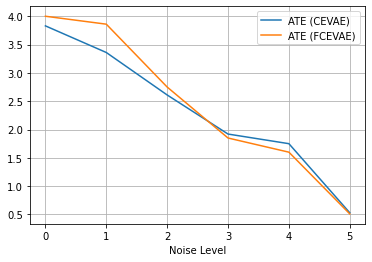

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

l = range(0, 10)
rgb =[[0,3.83, 4], [1,3.36, 3.86], [2, 2.61, 2.75], [3, 1.92, 1.85], [4, 1.75, 1.6] ,[5, 0.53, 0.51] ]
df = pd.DataFrame(rgb, columns=['sigma','ATE (CEVAE)', 'ATE (FCEVAE)'])


plt.plot(df['sigma'], df['ATE (CEVAE)'], label='ATE (CEVAE)')
plt.plot(df['sigma'], df['ATE (FCEVAE)'], label='ATE (FCEVAE)')
plt.xlabel('Noise Level')
plt.grid(True)
plt.legend()